In [19]:
from google.colab import drive
drive.mount('/content/drive')

!unzip '/content/drive/MyDrive/Post-Flood Disaster Management/Code/Segmentation/FloodNet-Supervised_v1.0.zip'

Archive:  /content/drive/MyDrive/Post-Flood Disaster Management/Code/Segmentation/FloodNet-Supervised_v1.0.zip
   creating: FloodNet-Supervised_v1.0/
  inflating: FloodNet-Supervised_v1.0/DATASET-VERSION-NOTE-v1.0.txt  
   creating: FloodNet-Supervised_v1.0/test/
   creating: FloodNet-Supervised_v1.0/test/test-label-img/
  inflating: FloodNet-Supervised_v1.0/test/test-label-img/10163.png  
  inflating: FloodNet-Supervised_v1.0/test/test-label-img/10164.png  
  inflating: FloodNet-Supervised_v1.0/test/test-label-img/10167.png  
  inflating: FloodNet-Supervised_v1.0/test/test-label-img/10174.png  
  inflating: FloodNet-Supervised_v1.0/test/test-label-img/10183.png  
  inflating: FloodNet-Supervised_v1.0/test/test-label-img/10808.png  
  inflating: FloodNet-Supervised_v1.0/test/test-label-img/10812.png  
  inflating: FloodNet-Supervised_v1.0/test/test-label-img/10813.png  
  inflating: FloodNet-Supervised_v1.0/test/test-label-img/10814.png  
  inflating: FloodNet-Supervised_v1.0/test/test

In [2]:
!nvidia-smi

Wed Feb 21 06:23:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              41W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [4]:
import os
import cv2
import glob
import pickle
import numpy as np
from tqdm import tqdm
from keras.utils import normalize
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from matplotlib.patches import Rectangle
from sklearn.metrics import average_precision_score

SIZE_X = 256
SIZE_Y = 256
n_channels = 3
n_classes = 10
Batch_size = 8
EPOCHS = 100
MODEL = 'unet'
BACKBONE = 'efficientnetb7'
encoder_weights = 'imagenet'
activation = 'softmax'
parent_directory = r'/content/FloodNet-Supervised_v1.0'
folder_path = f'/content/drive/MyDrive/Post-Flood Disaster Management/Code/Segmentation/UNET'

In [18]:
def load_images(parent_directory, split='train'):
    images = []
    masks = []

    image_folder_path = f'{parent_directory}/{split}/{split}-org-img'
    for img_path in tqdm(glob.glob(os.path.join(image_folder_path, "*.jpg"))):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        images.append(img)

        mask_path = (img_path.replace('org', 'label')).replace('jpg', 'png')
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)

    print(f'{split.upper()}: Images loaded: {images.shape[0]}')
    print(f'{split.upper()}: Masks loaded: {masks.shape[0]}')

    return images, masks

In [6]:
def preprocess_data(images, masks, unet_preporcessing):
    if unet_preporcessing:
        images = unet_preporcessing(images)
    else:
        images = normalize(images, axis=1)

    masks = np.expand_dims(masks, axis=-1)
    masks = to_categorical(masks, num_classes=n_classes)
    masks = masks.reshape((masks.shape[0], masks.shape[1], masks.shape[2], n_classes))

    return images, masks

In [7]:
class_map= {'Background':0, 'Building-flooded':1, 'Building-non-flooded':2, 'Road-flooded':3, 'Road-non-flooded':4, 'Water':5, 'Tree':6, 'Vehicle':7, 'Pool':8, 'Grass':9}

color_map = {'Background':[0, 0, 0], 'Building-flooded':[196, 0, 0], 'Building-non-flooded': [255,128,128], 'Road-flooded':[128, 128, 0],  'Road-non-flooded':[128, 128, 128],
                 'Water': [0, 191, 255], 'Tree':[34, 139, 34], 'Vehicle': [123, 37, 118],  'Pool':[0, 68, 255],'Grass':[127, 224, 104]}

handles = [Rectangle((0,0),1,1, color = (np.array(c)/255)) for n,c in color_map.items()]

labels = [n for n,c in color_map.items()]


def to_RGB(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    for key, val in class_map.items():
      label_seg [np.all(label == class_map[key],axis=-1)] = color_map[key]
    return label_seg

def display_images_with_masks(image, mask, predicted):
    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.title('Testing Image')
    plt.imshow(image)
    plt.subplot(132)
    plt.title('Testing Label')
    plt.imshow(to_RGB(np.tile(np.expand_dims(mask, axis=-1), (1, 1, 3))))
    plt.subplot(133)
    plt.title('Prediction')
    plt.imshow(to_RGB(np.tile(np.expand_dims(predicted, axis=-1), (1, 1, 3))))
    plt.legend(handles, labels, bbox_to_anchor =(-0.8,-0.5), loc='lower center', ncol=5)
    plt.show() 

In [ ]:
#Load the images
train_images, train_masks = load_images(parent_directory, split='train')
val_images, val_masks = load_images(parent_directory, split='val')

100%|██████████| 450/450 [01:58<00:00,  3.79it/s]

VAL: Images loaded: 450
VAL: Masks loaded: 450


In [ ]:
data_to_save = {
    'train_images': train_images,
    'train_masks': train_masks,
    'val_images': val_images,
    'val_masks': val_masks
}

pickle_file_path = f'{folder_path}/dataset/train_and_val_data.pickle'

with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(data_to_save, pickle_file)

print(f'Data saved to {pickle_file_path}')

print('Shapes of loaded data:')
print('Train Images:', train_images.shape)
print('Train Masks:', train_masks.shape)
print('Val Images:', val_images.shape)
print('Val Masks:', val_masks.shape)

Data saved to /content/drive/MyDrive/Post-Flood Disaster Management/Code/Segmentation/UNET/dataset/train_and_val_data.pickle
Shapes of loaded data:
Train Images: (1445, 256, 256, 3)
Train Masks: (1445, 256, 256)
Val Images: (450, 256, 256, 3)
Val Masks: (450, 256, 256)


In [8]:
pickle_file_path = f'{folder_path}/dataset/train_and_val_data.pickle'

with open(pickle_file_path, 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

train_images = loaded_data['train_images']
train_masks = loaded_data['train_masks']
val_images = loaded_data['val_images']
val_masks = loaded_data['val_masks']

print('Shapes of loaded data:')
print('Train Images:', train_images.shape)
print('Train Masks:', train_masks.shape)
print('Val Images:', val_images.shape)
print('Val Masks:', val_masks.shape)

Shapes of loaded data:
Train Images: (1445, 256, 256, 3)
Train Masks: (1445, 256, 256)
Val Images: (450, 256, 256, 3)
Val Masks: (450, 256, 256)


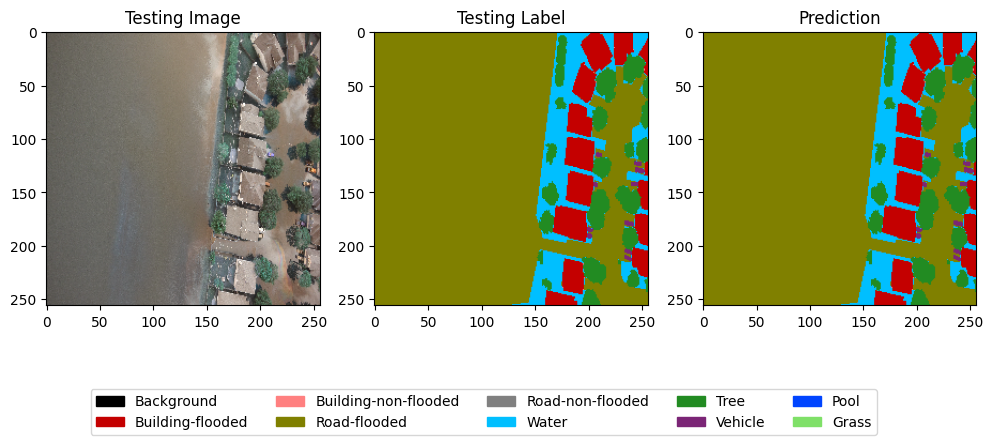

In [10]:
random_image_num = np.random.randint(0, train_images.shape[0])
display_images_with_masks(train_images[random_image_num], train_masks[random_image_num], train_masks[random_image_num])

In [11]:
!pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 7.1 MB/s eta 0:00:00


In [12]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

preprocess_input = sm.get_preprocessing(BACKBONE)

train_images, train_masks = preprocess_data(train_images, train_masks, preprocess_input)
val_images, val_masks = preprocess_data(val_images, val_masks, preprocess_input)

print('Shapes of loaded data:')
print('Train Images:', train_images.shape)
print('Train Masks:', train_masks.shape)
print('Val Images:', val_images.shape)
print('Val Masks:', val_masks.shape)

Segmentation Models: using `tf.keras` framework.
Shapes of loaded data:
Train Images: (1445, 256, 256, 3)
Train Masks: (1445, 256, 256, 10)
Val Images: (450, 256, 256, 3)
Val Masks: (450, 256, 256, 10)


In [13]:
if MODEL == 'unet':
    model = sm.Unet(BACKBONE, input_shape=(SIZE_X, SIZE_Y, n_channels), classes=n_classes, encoder_weights=encoder_weights,  activation=activation)
elif MODEL == 'fpn':
    model = sm.FPN(BACKBONE, input_shape=(SIZE_X, SIZE_Y, n_channels), classes=n_classes, encoder_weights=encoder_weights,  activation=activation)
elif MODEL == 'pspnet':
    model = sm.PSPNet(BACKBONE, input_shape=(SIZE_X, SIZE_Y, n_channels), classes=n_classes, encoder_weights=encoder_weights,  activation=activation)
elif MODEL == 'linknet':
    model = sm.Linknet(BACKBONE, input_shape=(SIZE_X, SIZE_Y, n_channels), classes=n_classes, encoder_weights=encoder_weights,  activation=activation)
else:
    raise ValueError('Unknown model')

model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
model.summary()

258434480/258434480 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 128, 128, 64)         1728      ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 128, 128, 64)         256       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio

In [14]:
history = model.fit(x=train_images, y=train_masks, batch_size=Batch_size, epochs=EPOCHS, validation_data=(val_images, val_masks))

Epoch 1/100
181/181 [==============================] - 180s 257ms/step - loss: 0.9614 - iou_score: 0.2346 - val_loss: 0.8872 - val_iou_score: 0.2509
Epoch 2/100
181/181 [==============================] - 37s 203ms/step - loss: 0.7432 - iou_score: 0.3641 - val_loss: 3.9690 - val_iou_score: 0.1031
Epoch 3/100
181/181 [==============================] - 37s 203ms/step - loss: 0.6716 - iou_score: 0.4226 - val_loss: 0.6654 - val_iou_score: 0.4276
Epoch 4/100
181/181 [==============================] - 37s 203ms/step - loss: 0.6426 - iou_score: 0.4461 - val_loss: 0.6421 - val_iou_score: 0.4517
Epoch 5/100
181/181 [==============================] - 37s 203ms/step - loss: 0.6087 - iou_score: 0.4752 - val_loss: 0.6624 - val_iou_score: 0.4357
Epoch 6/100
181/181 [==============================] - 37s 203ms/step - loss: 0.5871 - iou_score: 0.4946 - val_loss: 0.5598 - val_iou_score: 0.5133
Epoch 7/100
181/181 [==============================] - 37s 203ms/step - loss: 0.5465 - iou_score: 0.5291 - val_

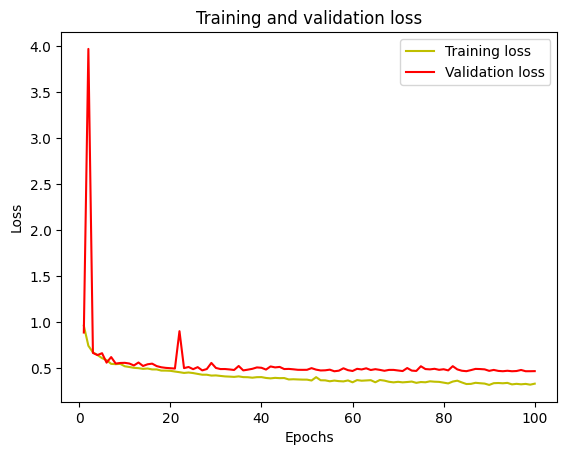

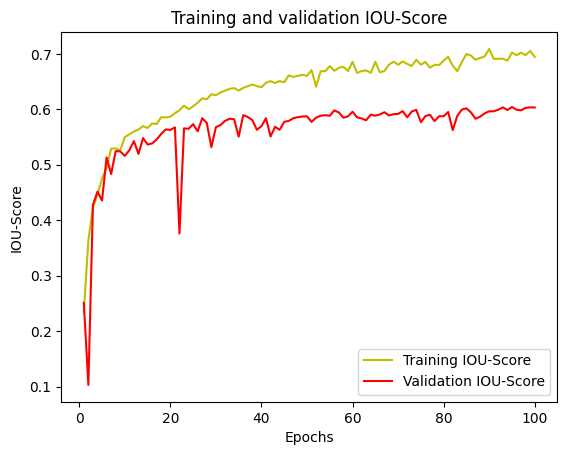

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU-Score')
plt.plot(epochs, val_acc, 'r', label='Validation IOU-Score')
plt.title('Training and validation IOU-Score')
plt.xlabel('Epochs')
plt.ylabel('IOU-Score')
plt.legend()
plt.show()

In [16]:
model.save(f'{folder_path}/weights/{MODEL.upper()}_model_with_{EPOCHS}_epochs({MODEL.upper()}_{BACKBONE.capitalize()}).hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.load_weights(f'weights/{MODEL.upper()}_model_with_{EPOCHS}_epochs({MODEL.upper()}_{BACKBONE.capitalize()}).hdf5')

In [20]:
test_images, test_masks = load_images(parent_directory, split='test')
test_images_seperate = test_images

test_images, test_masks = preprocess_data(test_images, test_masks, preprocess_input)

100%|██████████| 448/448 [01:48<00:00,  4.14it/s]


TEST: Images loaded: 448
TEST: Masks loaded: 448


In [21]:
data_to_save = {
    'test_images': test_images,
    'test_masks': test_masks,
    'test_images_seperate': test_images_seperate
}

pickle_file_path = f'{folder_path}/dataset/test_data.pickle'

with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(data_to_save, pickle_file)

print(f'Data saved to {pickle_file_path}')

print('Shapes of loaded data:')
print('Test Images:', test_images.shape)
print('Test Masks:', test_masks.shape)

Data saved to /content/drive/MyDrive/Post-Flood Disaster Management/Code/Segmentation/UNET/dataset/test_data.pickle
Shapes of loaded data:
Test Images: (448, 256, 256, 3)
Test Masks: (448, 256, 256, 10)


In [23]:
pickle_file_path = f'{folder_path}/dataset/test_data.pickle'

with open(pickle_file_path, 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

test_images = loaded_data['test_images']
test_masks = loaded_data['test_masks']
test_images_seperate = loaded_data['test_images_seperate']

print('Shapes of loaded data:')
print('Test Images:', test_images.shape)
print('Test Masks:', test_masks.shape)

Shapes of loaded data:
Test Images: (448, 256, 256, 3)
Test Masks: (448, 256, 256, 10)


In [24]:
_, acc = model.evaluate(test_images, test_masks, verbose=0)
print("Accuracy is = ", (acc * 100.0), "%")

Accuracy is =  69.98142600059509 %


In [25]:
from keras.metrics import MeanIoU
import numpy as np

y_pred = model.predict(test_images)
predicted_masks = np.argmax(y_pred, axis=-1)
test_masks_ = np.argmax(test_masks, axis=-1)

print(predicted_masks.shape)
print(test_masks_.shape)

14/14 [==============================] - 6s 117ms/step
(448, 256, 256)
(448, 256, 256)


In [26]:
class_names = ["Background", "Building Flooded", "Building Non-Flooded", "Road Flooded", "Road Non-Flooded",
               "Water", "Tree", "Vehicle", "Pool", "Grass"]

n_classes = len(class_names)
IOU_keras = MeanIoU(num_classes=n_classes)

IOU_keras.update_state(test_masks_, predicted_masks)
print("Mean IoU =", IOU_keras.result().numpy())

values = np.array(IOU_keras.get_weights())
values = values.reshape(n_classes, n_classes)

class_IoUs = []
print("IoU for each class:")
for i in range(n_classes):
    if i == 0:
        continue
    class_IoU = values[i, i] / (np.sum(values[i, :]) + np.sum(values[:, i]) - values[i, i])
    class_IoUs.append(class_IoU)
    print(f"{class_names[i]}: {class_IoU}")

mean_IoU_without_background = np.mean(class_IoUs)
print("Mean IoU (excluding Background):", mean_IoU_without_background)

Mean IoU = 0.71127856
IoU for each class:
Building Flooded: 0.7241079211235046
Building Non-Flooded: 0.7931119799613953
Road Flooded: 0.6545457243919373
Road Non-Flooded: 0.8322752118110657
Water: 0.7884145379066467
Tree: 0.8444666862487793
Vehicle: 0.4714009761810303
Pool: 0.534946858882904
Grass: 0.9052640199661255
Mean IoU (excluding Background): 0.7276148


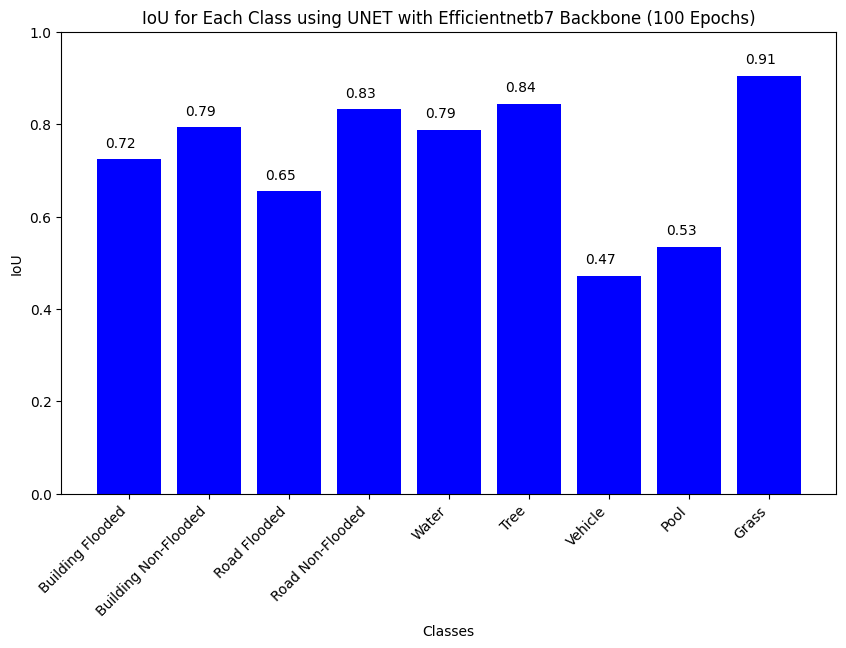

In [28]:
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names[1:], class_IoUs, color='blue')
plt.title(f'IoU for Each Class using {MODEL.upper()} with {BACKBONE.capitalize()} Backbone ({EPOCHS} Epochs)')
plt.xlabel('Classes')
plt.ylabel('IoU')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')

for bar, value in zip(bars, class_IoUs):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.02, f'{value:.2f}', ha='center', va='bottom')

plt.show()

In [29]:
def display_random_function():
    image_id = np.random.randint(0, len(test_images))
    image = test_images_seperate[image_id]
    ground_truth_mask = test_masks_[image_id]
    predicted_mask = predicted_masks[image_id]

    print(f'Image Shape: {image.shape}')
    print(f'Ground Truth Mask Shape: {ground_truth_mask.shape}')
    print(f'Predicted Mask Shape: {predicted_mask.shape}')

    display_images_with_masks(image, ground_truth_mask, predicted_mask)

Image Shape: (256, 256, 3)
Ground Truth Mask Shape: (256, 256)
Predicted Mask Shape: (256, 256)


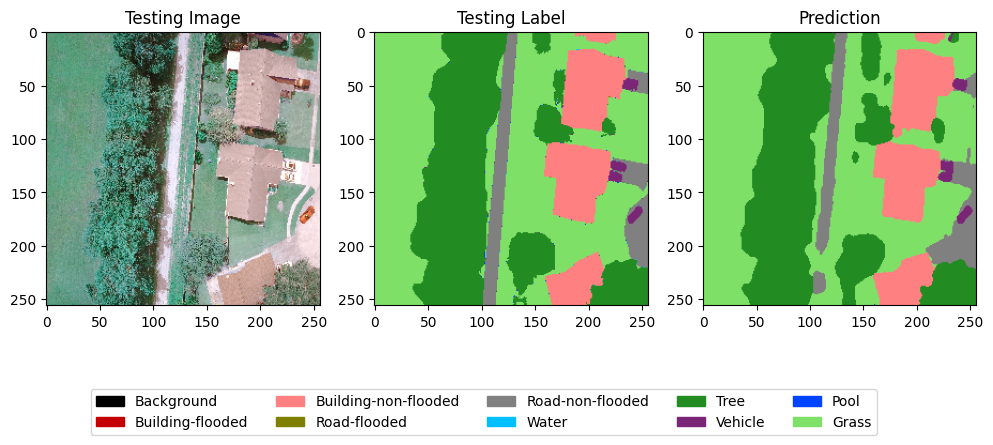

In [35]:
display_random_function()

Image Shape: (256, 256, 3)
Ground Truth Mask Shape: (256, 256)
Predicted Mask Shape: (256, 256)


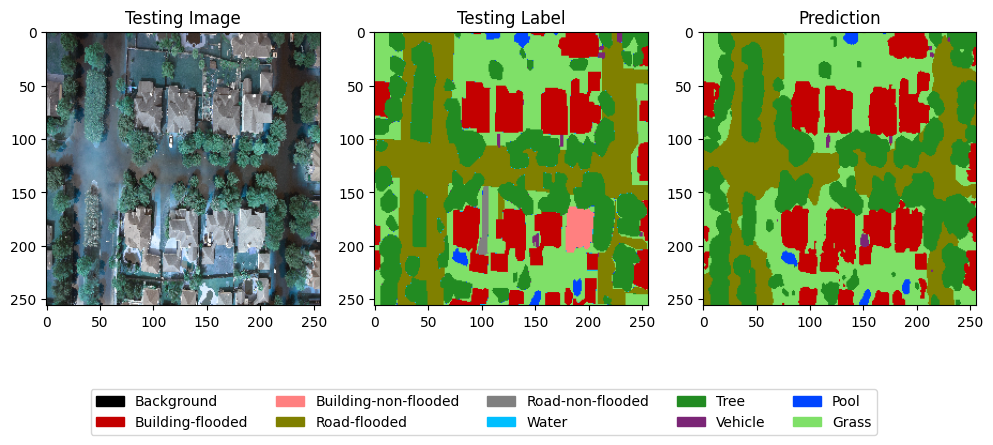

In [31]:
display_random_function()

Image Shape: (256, 256, 3)
Ground Truth Mask Shape: (256, 256)
Predicted Mask Shape: (256, 256)


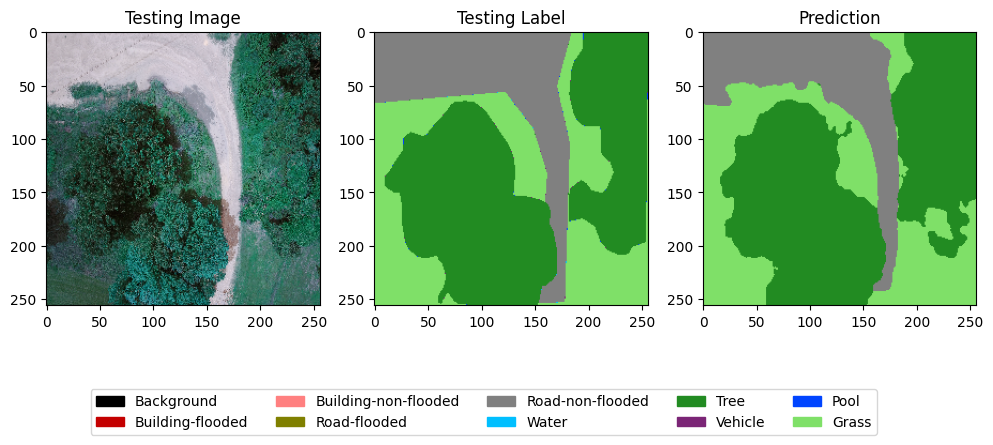

In [36]:
display_random_function()

Image Shape: (256, 256, 3)
Ground Truth Mask Shape: (256, 256)
Predicted Mask Shape: (256, 256)


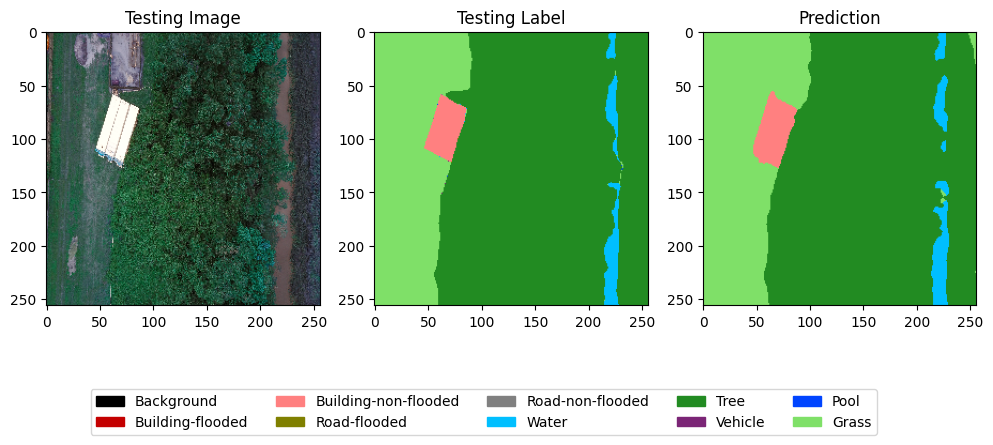

In [38]:
display_random_function()

Image Shape: (256, 256, 3)
Ground Truth Mask Shape: (256, 256)
Predicted Mask Shape: (256, 256)


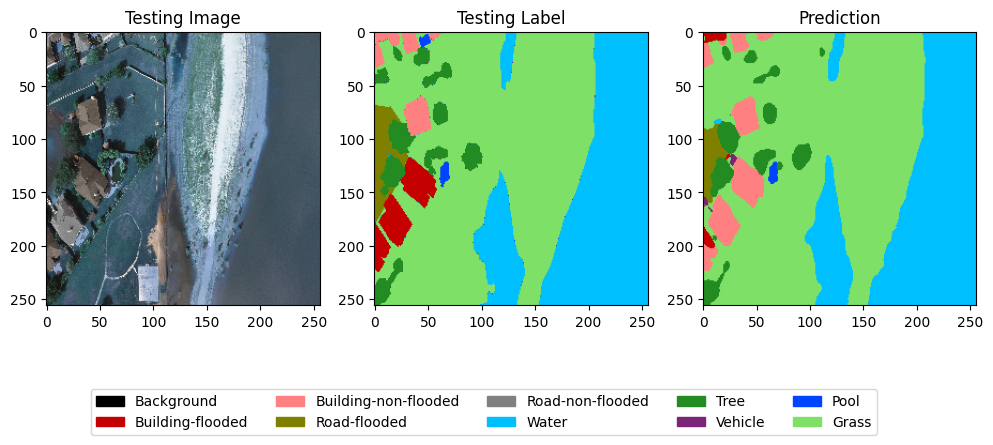

In [40]:
display_random_function()